## Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from catboost import CatBoostClassifier
import os
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

pd.set_option('display.max_rows', None)  # None means unlimited rows
pd.set_option('display.max_columns', None)  # None means unlimited columns'

<span style="font-size: 22px;">Create Directory if it doesnot exist</span>

In [2]:
# Define the relative directory path
relative_dir = r'..\model'

# Check if the directory exists and create it if it doesn't
if not os.path.exists(relative_dir):
    os.makedirs(relative_dir)
    print(f"Directory created: {relative_dir}")
else:
    print(f"Directory already exists: {relative_dir}")


Directory created: ..\model


In [3]:
# Define the relative directory path
relative_dir = r'..\output\predictions'

# Check if the directory exists and create it if it doesn't
if not os.path.exists(relative_dir):
    os.makedirs(relative_dir)
    print(f"Directory created: {relative_dir}")
else:
    print(f"Directory already exists: {relative_dir}")


Directory created: ..\output\predictions


<span style="font-size: 22px;">Read the dataset</span>

In [4]:
file_path = '../output/finalData.csv'
data = pd.read_csv(file_path)

data = data.sort_values(by='kay_contactid')

# #data = data.sample(n=120000)
# data = data.iloc[1200:3000]

In [5]:
data.head(3)

,kay_contactid,Gender,birthdate,HNI Customer,Customer Concern,age,abs_age,age_range,Zone,Item,BusinessUnit,InvoiceCenterCode,Promotion,TierName,finalInvoiceId,FinalAmount,Category,PackageCode,Marketbucket,CenterCode,Invoicecenter,PackageValiditydays,Free,AQU,status2,ExistNewTag,Churn,month,year
1661,535878,Male,2000-01-01,No,NaN,24,24,20-30,NORTH-Abhishek S,Package,ANTI-AGEING,KAS1,Campaign: EMP - 40% OFF ON HIFU-THERMAGE-ULTHERA,NaN,1D82BB3C-1205-4DAF-B616-83E5B2ECA415,69096,YOUTH RENEW MARVEL WITH THERMAGE,SOL-805-001,ANTI-AGEING,KAS1,NaN,90,no,No,LIVE,New,0,12,2021
1699,ACSH29,Female,2003-08-06,Yes,NaN,21,21,20-30,Academy,Package,Academy Course,TA02,Manual Discount,Platinum,27219E6C-CDBB-4A4B-8B02-87A11CD637A1,101244,SOOTHE AND BALANCE FACIAL,ACCourse-01-08,BEAUTY FACIALS,TA02,NaN,48,no,No,NaN,Existing,1,10,2021
1700,ACSH29,Female,2003-08-06,Yes,NaN,21,21,20-30,Academy,Package,Academy Course,TA02,Manual Discount,Platinum,27219E6C-CDBB-4A4B-8B02-87A11CD637A1,101244,OTHER,ACCourse-01-08,NaN,TA02,NaN,48,no,No,NaN,Existing,1,10,2021


<span style="font-size: 22px;">Define numerical and categorical features</span>

In [6]:
# Assuming 'data' is your pandas DataFrame containing the dataset
num_features = ['PackageValiditydays']
cat_features = ['age_range', 'Gender', 'HNI Customer', 'Zone', 'Item', 'BusinessUnit', 'TierName',
                'Marketbucket', 'Free', 'AQU', 'status2', 'ExistNewTag', 'FinalAmount',
                'InvoiceCenterCode', 'Promotion', 'Category', 'PackageCode',
                'CenterCode', 'finalInvoiceId', 'month', 'year']

target_feature = 'Churn'


<span style="font-size: 22px;">Split dataset into training, validation, and test sets on basis of 'kay_contactid's </span>

In [7]:
# Group data by 'kay_contactid'
contact_groups = data.groupby('kay_contactid')

# Get unique 'kay_contactid's
contact_ids = list(contact_groups.groups.keys())

# Shuffle 'kay_contactid's
random.shuffle(contact_ids)

# Split 'kay_contactid's into training, validation, and test sets
train_contact_ids, test_contact_ids = train_test_split(contact_ids, test_size=0.2, random_state=42)
train_contact_ids, val_contact_ids = train_test_split(train_contact_ids, test_size=0.1, random_state=42)

# Filter data for training, validation, and test sets based on 'kay_contactid'
train_data = pd.concat([contact_groups.get_group(cid) for cid in train_contact_ids])
val_data = pd.concat([contact_groups.get_group(cid) for cid in val_contact_ids])
test_data = pd.concat([contact_groups.get_group(cid) for cid in test_contact_ids])

<span style="font-size: 22px;">Prepare X and y for training, validation, and test sets </span>

In [8]:
# Prepare X and y for training, validation, and test sets
X_train = train_data.drop(['kay_contactid', target_feature], axis=1)
y_train = train_data[target_feature]
X_val = val_data.drop(['kay_contactid', target_feature], axis=1)
y_val = val_data[target_feature]
X_test = test_data.drop(['kay_contactid', target_feature], axis=1)
y_test = test_data[target_feature]

# Check if all cat_features are in X_train
missing_features = set(cat_features) - set(X_train.columns)
if missing_features:
    raise ValueError(f"Missing columns in X_train: {missing_features}")

<span style="font-size: 22px;">Preprocess numerical features (standard scaling)</span>

In [9]:
# Preprocess numerical features (standard scaling)
num_transformer = StandardScaler()
X_train_num = num_transformer.fit_transform(X_train[num_features])
X_val_num = num_transformer.transform(X_val[num_features])
X_test_num = num_transformer.transform(X_test[num_features])

<span style="font-size: 22px;">Preprocess categorical features (one-hot encoding) </span>

In [10]:
# Preprocess categorical features (one-hot encoding)
cat_transformer = OneHotEncoder(handle_unknown='ignore')
cat_transformer.fit(X_train[cat_features])  # Fit the transformer only on X_train
X_train_cat = cat_transformer.transform(X_train[cat_features])
X_val_cat = cat_transformer.transform(X_val[cat_features])
X_test_cat = cat_transformer.transform(X_test[cat_features])

<span style="font-size: 22px;">Concatenate processed numerical and categorical features for training, validation, and test set</span>

In [11]:
# Concatenate processed numerical and categorical features for training, validation, and test sets
X_train_processed = pd.concat([pd.DataFrame(X_train_num, columns=num_features),
                               pd.DataFrame(X_train_cat.toarray(), columns=cat_transformer.get_feature_names_out(cat_features))],
                              axis=1)

X_val_processed = pd.concat([pd.DataFrame(X_val_num, columns=num_features),
                             pd.DataFrame(X_val_cat.toarray(), columns=cat_transformer.get_feature_names_out(cat_features))],
                            axis=1)

X_test_processed = pd.concat([pd.DataFrame(X_test_num, columns=num_features),
                              pd.DataFrame(X_test_cat.toarray(), columns=cat_transformer.get_feature_names_out(cat_features))],
                             axis=1)

<span style="font-size: 22px;">Check for the distribution of the target 'Churn' as 0 or 1 in each dataset</span>

In [12]:
print(f"Training set target distribution:\n{y_train.value_counts()}")
print(f"Validation set target distribution:\n{y_val.value_counts()}")
print(f"Test set target distribution:\n{y_test.value_counts()}")

Training set target distribution:
Churn
0    742
1    504
Name: count, dtype: int64
Validation set target distribution:
Churn
0    81
1    57
Name: count, dtype: int64
Test set target distribution:
Churn
0    218
1    141
Name: count, dtype: int64


In [13]:
print(f"Unique values in y_train: {y_train.unique()}")
print(f"Unique values in y_val: {y_val.unique()}")
print(f"Unique values in y_test: {y_test.unique()}")

Unique values in y_train: [0 1]
Unique values in y_val: [0 1]
Unique values in y_test: [0 1]


## Model Definition

In [14]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=500,  # You can adjust the number of iterations
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

## Model Training on train dataset

In [15]:
# Train the model
model.fit(X_train_processed, y_train, eval_set=(X_val_processed, y_val), early_stopping_rounds=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6075441	test: 0.4855072	best: 0.4855072 (0)	total: 182ms	remaining: 1m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6014492754
bestIteration = 12

Shrink model to first 13 iterations.


In [16]:
# Retrieve the training and validation metrics directly during fitting
train_metrics = model.get_best_score()  # Best score does not give all iterations

# Plotting metrics using built-in functionality
plt.figure(figsize=(12, 6))

# # Loss Curve
# plt.subplot(1, 2, 1)
# plt.plot(model.get_eval_results()['learn']['Logloss'], label='Training Loss', color='blue')
# plt.plot(model.get_eval_results()['validation']['Logloss'], label='Validation Loss', color='orange')
# plt.xlabel('Iterations')
# plt.ylabel('Logloss')
# plt.title('Loss Curve')
# plt.legend()

# # Accuracy Curve
# plt.subplot(1, 2, 2)
# plt.plot(model.get_eval_results()['learn']['Accuracy'], label='Training Accuracy', color='blue')
# plt.plot(model.get_eval_results()['validation']['Accuracy'], label='Validation Accuracy', color='orange')
# plt.xlabel('Iterations')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Curve')
# plt.legend()

# plt.tight_layout()
# plt.show()


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

## Model Prediction on test dataset

In [17]:
# Predict on the test set
y_pred = model.predict(X_test_processed)

## Model Evaluation

In [18]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# # Plot feature importance
# feature_importances = model.get_feature_importance()
# plt.barh(X_train_processed.columns, feature_importances)
# plt.title('Feature Importance')
# plt.show()

Test Accuracy: 0.596100278551532
Precision: 0.35714285714285715
Recall: 0.03546099290780142
F1 Score: 0.06451612903225806
Confusion Matrix:
[[209   9]
 [136   5]]


## Performance Metrics

<span style="font-size: 22px;">Classification Report</span>

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.96      0.74       218
           1       0.36      0.04      0.06       141

    accuracy                           0.60       359
   macro avg       0.48      0.50      0.40       359
weighted avg       0.51      0.60      0.48       359



<span style="font-size: 22px;">Confusion Matrix</span>

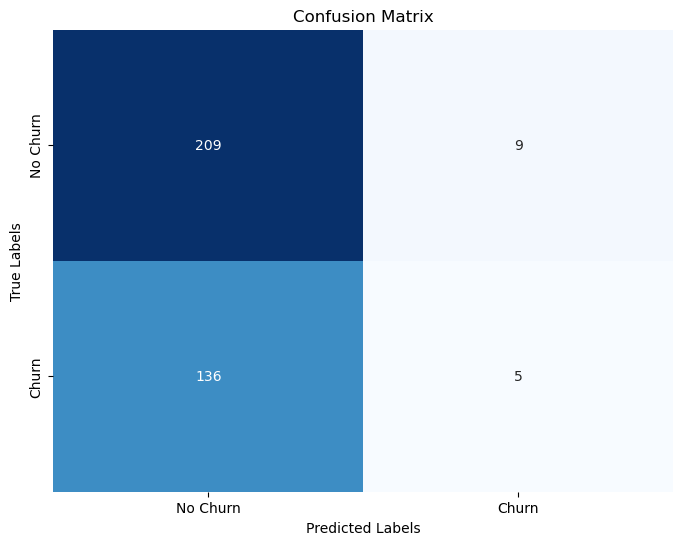

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are already defined
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


<span style="font-size: 22px;">AUC ROC Curve</span>

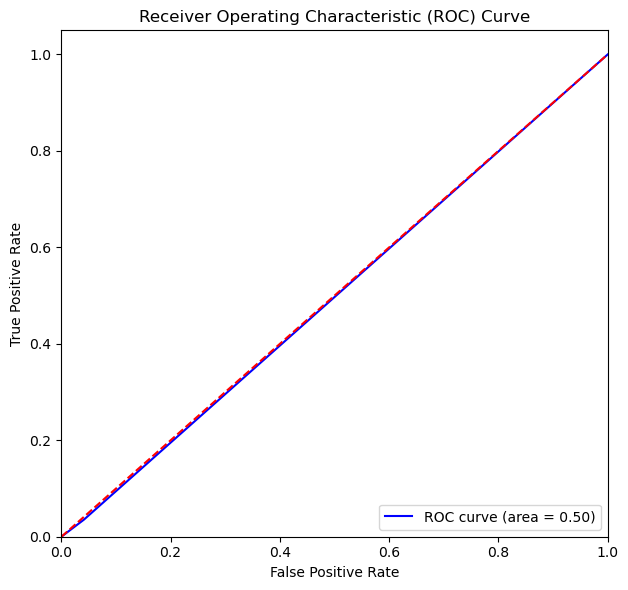

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Assuming y_test and y_pred_proba are already defined
# y_pred_proba should be the predicted probabilities for the positive class (Churn)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.tight_layout()
plt.show()


<span style="font-size: 22px;">Precision Recall Curve</span>

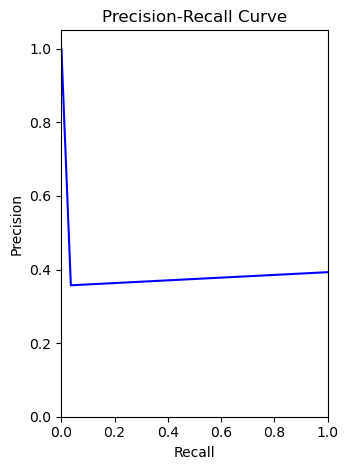

In [22]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

<span style="font-size: 22px;">Correct and Incorrect predictions</span>

In [23]:
# Create a DataFrame to hold the data along with predictions
data_with_predictions = pd.DataFrame(X_test, columns=X_test.columns)
data_with_predictions['Actual'] = y_test
data_with_predictions['Predicted'] = y_pred

# Display rows with correct and incorrect predictions
correct_predictions = data_with_predictions[data_with_predictions['Actual'] == data_with_predictions['Predicted']]
incorrect_predictions = data_with_predictions[data_with_predictions['Actual'] != data_with_predictions['Predicted']]

## Model and Pipeline Save

<span style="font-size: 22px;">Saving the Model</span>

In [24]:
import joblib
from catboost import CatBoostClassifier

# Assuming the model is already trained and the pre-processing pipeline is defined
# Save the trained CatBoost model
model.save_model("../model/catboost_model.cbm")

<span style="font-size: 22px;">Saving the pipeline</span>

In [25]:
# Save the numerical scaler (StandardScaler) and categorical transformer (OneHotEncoder) with joblib
preprocessing_pipeline = {
    'num_transformer': num_transformer,  # StandardScaler
    'cat_transformer': cat_transformer   # OneHotEncoder
}

# Save the pipeline using joblib
joblib.dump(preprocessing_pipeline, '../model/preprocessing_pipeline.pkl')

print("Model and preprocessing pipeline saved successfully!")

Model and preprocessing pipeline saved successfully!


<span style="font-size: 22px;">Saving the predictions</span>

In [26]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
import joblib

# Load the CatBoost model and preprocessing pipeline
loaded_model = CatBoostClassifier()
loaded_model.load_model("../model/catboost_model.cbm")

loaded_pipeline = joblib.load('../model/preprocessing_pipeline.pkl')
num_transformer = loaded_pipeline['num_transformer']
cat_transformer = loaded_pipeline['cat_transformer']

# Assuming you have the test data 'X_test' and true labels 'y_test'

# Preprocess the test data
X_test_num = num_transformer.transform(X_test[num_features])
X_test_cat = cat_transformer.transform(X_test[cat_features])

# Concatenate the processed numerical and categorical features
X_test_processed = pd.concat([pd.DataFrame(X_test_num, columns=num_features),
                              pd.DataFrame(X_test_cat.toarray(), columns=cat_transformer.get_feature_names_out(cat_features))],
                             axis=1)



# Make predictions using the loaded CatBoost model
y_pred = loaded_model.predict(X_test_processed)

# Compare predictions with true labels
correct_predictions = X_test[y_test == y_pred]
incorrect_predictions = X_test[y_test != y_pred]

# Show correct and incorrect predictions
print("Correct Predictions:")
print(correct_predictions)

print("\nIncorrect Predictions:")
print(incorrect_predictions)

# Optionally, you can also display the counts
print(f"\nNumber of Correct Predictions: {len(correct_predictions)}")
print(f"Number of Incorrect Predictions: {len(incorrect_predictions)}")

# Optionally, save the correct and incorrect predictions to CSV files
correct_predictions.to_csv('..\output\predictions\correct_predictions.csv', index=False)
incorrect_predictions.to_csv('..\output\predictions\incorrect_predictions.csv', index=False)


<>:46: SyntaxWarning: invalid escape sequence '\o'
<>:47: SyntaxWarning: invalid escape sequence '\o'
<>:46: SyntaxWarning: invalid escape sequence '\o'
<>:47: SyntaxWarning: invalid escape sequence '\o'
C:\Users\goenk\AppData\Local\Temp\ipykernel_17244\477606264.py:46: SyntaxWarning: invalid escape sequence '\o'
  correct_predictions.to_csv('..\output\predictions\correct_predictions.csv', index=False)
C:\Users\goenk\AppData\Local\Temp\ipykernel_17244\477606264.py:47: SyntaxWarning: invalid escape sequence '\o'
  incorrect_predictions.to_csv('..\output\predictions\incorrect_predictions.csv', index=False)


Correct Predictions:
      Gender   birthdate HNI Customer  Customer Concern  age  abs_age  \
574     Male  1982-09-17           No               NaN   42       42   
575     Male  1982-09-17           No               NaN   42       42   
135   Female  1998-07-17          Yes               NaN   26       26   
439      NaN  2000-01-01          Yes               NaN   24       24   
440      NaN  2000-01-01          Yes               NaN   24       24   
441      NaN  2000-01-01          Yes               NaN   24       24   
1474  Female  1987-08-16          Yes               NaN   37       37   
1020  Female  2000-01-01          Yes               NaN   24       24   
1219  Female  1982-10-29          Yes               NaN   41       41   
1218  Female  1982-10-29          Yes               NaN   41       41   
1220  Female  1982-10-29          Yes               NaN   41       41   
1356  Female  1997-10-01          Yes               NaN   26       26   
406   Female  2000-01-01      

## Calculate Retention Ratio:
The retention ratio can be calculated as the percentage of customers who did not churn (i.e., stayed with the service) over a given period. This can be derived from the predictions of your churn model on the test dataset.

In [27]:
# Assuming 'predictions_df' contains the actual and predicted churn labels for the test set

# Calculate the total number of customers
total_customers = len(data_with_predictions)

# Calculate the number of customers who did not churn (True negatives)
retained_customers = len(data_with_predictions[data_with_predictions['Actual'] == data_with_predictions['Predicted']])

# Calculate the retention ratio (percentage of retained customers)
retention_ratio = (retained_customers / total_customers) * 100

print(f"Retention Ratio: {retention_ratio:.2f}%")


Retention Ratio: 59.61%


# Calculate Customer Lifetime Value (CLV):
Customer Lifetime Value (CLV) estimates the total value a customer will bring to the business over their entire relationship with the company. It's typically calculated based on the predicted churn probabilities and expected revenue.

In [28]:
# Check the column names in predictions_df
#print(predictions_df.columns)

# Calculate CLV based on predicted churn probabilities and total amount
data_with_predictions['CLV'] = data_with_predictions['Predicted'] * data_with_predictions['FinalAmount']

In [29]:
# Calculate total CLV for all customers in the test set
total_clv = data_with_predictions['CLV'].sum()

print(f"Total Customer Lifetime Value (CLV): {total_clv:.2f}")


Total Customer Lifetime Value (CLV): 587598.00
